# Run the whole deltas algorithm

In [146]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pipeline
import deltas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get data and classifier

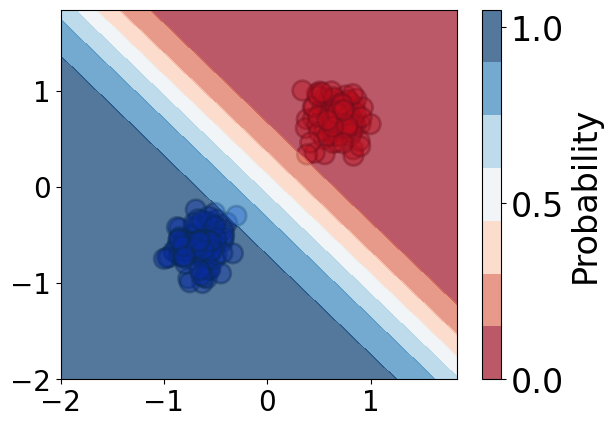

In [147]:
N1 = 100
N2 = 100
data_clf = pipeline.get_data_and_classifier(N1=N1, N2=N2)

data = data_clf['data']
clf = data_clf['clf']
m1 = data_clf['mean1']
m2 = data_clf['mean2']

## Get projection and data we need (R, D, M etc.)

R1 empirical: 0.4769898339253425
R2 empirical: 0.4659683371844019


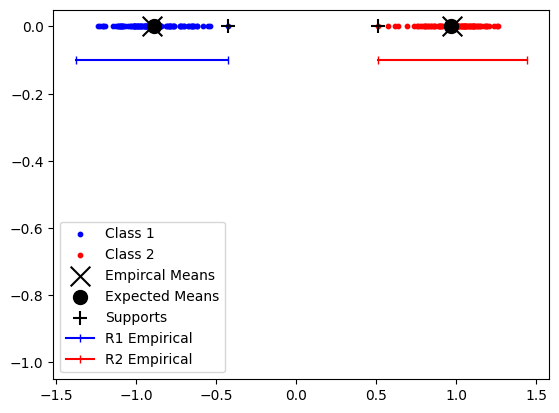

In [148]:
data_info = pipeline.data_project_and_info(
    data=data_clf['data'], m1=data_clf['mean1'], m2=data_clf['mean2'], clf=data_clf['clf'], data_test=data_clf['data_test'])

## set up extra parameters

In [149]:
# Costs
data_info['c1'] = 1
data_info['c2'] = 1
data_info['N1'] = N1
data_info['N2'] = N2
pipeline.print_params(data_info)

Parameters
        R:  1.264503285051425
        N1: 100
        N2: 100
        R1: 0.4769898339253425
        R2: 0.4659683371844019
        M:  0.9341964367121061
        D:  1.8771546078218504
        C1: 1
        C2: 1


## Optimiser

constraint init: 0.07740619132903404 should equal 0
delta1 : 1.0 
delta2: 1.0
constraint: 0.07740619132903404 should equal 0
R1_est : 0.9827911479459126 
R2_est: 0.9717696512049719


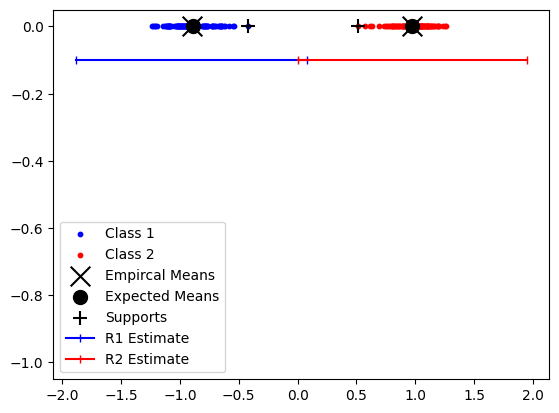

In [150]:

loss_func = deltas.scipy_optim_func   # returns tuple for (loss_func, gradient)
loss_func = deltas.loss_one_delta   # loss_func only - won't use gradient during optimisation
loss_func = lambda delta, data_info: deltas.loss(delta[0], delta[1], data_info)

contraint_func = deltas.contraint_eq7
# contraint_func = deltas.contraint_eq8

delta1_from_delta2_func = deltas.delta2_given_delta1
 
delta1, delta2 = pipeline.optimise(
    data_info, loss_func, contraint_func, num_deltas=2)

# Evaluation on test data

In [151]:
pipeline.eval_test(data_clf, data_info, delta1, delta2)

original accuracy: 1.0
deltas   accuracy: 1.0
